# Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as tt

____
#### Before we load the data, it is required to first prepare the transformations to be applied. It is an important step to prepare the data for training to avoid overfitting problem.
____

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Loading Data

In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


_____

# BATCHSIZE & DataLoader

In [6]:
BATCH_SIZE = 64
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=2, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=2, pin_memory=True)

# Visualization

# Get CUDA ready

In [7]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


In [8]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [9]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

# BaseModel

In [11]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]
    layers = first_layers + second_layers
    return nn.Sequential(*layers)

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out
        

In [15]:
model = ResNet(3,100)

In [16]:
model = to_device(model, device)

# Evaluation & Fit Function for Training

In [17]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    history = []
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history
            

# Hyperparameters

- **max_lr**: is the maximum learning rate that we set for learning rate scheduler. For the learning rate scheduler we used OneCycleLR, which sets the learning rate to a low learning rate, gradually increases it to the max learning rate then goes back to a low learning rate. <br/>
- **grad_clip**: prevents the gradients to become too large. <br/>
- **weight_decay**: essentially tries to make the model simple and helps the model generalise better.


In [20]:
epochs = 100
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [19]:
epochs = 50

# Training

In [ ]:
'''%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)
'''

'%%time\nhistory = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, \n              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,\n              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)\n'

In [ ]:
PATH = 'final_model.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
from IPython.display import FileLink
FileLink(PATH)

/kaggle/working/final_model.pth

In [21]:
PATH = '/kaggle/input/model-weighs/final_model.pth'
model.load_state_dict(torch.load(PATH))
model.eval()
print()

# Plotting

In [22]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-x")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-bx")
    plt.plot([x["val_loss"] for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

In [23]:
# plot_loss(history)

In [24]:
# plot_acc(history)

In [25]:
# plot_lrs(history)

# Make predictions and see the image with its result


In [26]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

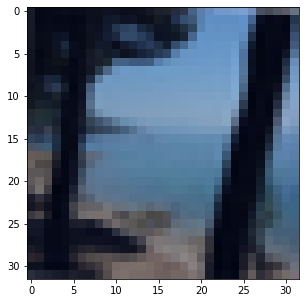

In [29]:
#test_data[56][0]
def imshow(img):
    # mu=0.5 sigma=0.2
    img = img / 5.1 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(test_data[10][0])

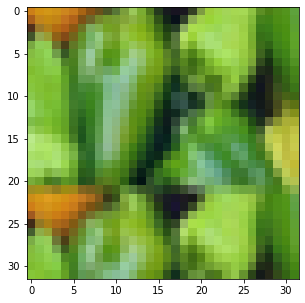

Label: sweet_pepper , Predicted: sweet_pepper


In [31]:
img, label = test_data[5800]
imshow(img)
print('Label:', test_data.classes[label], ', Predicted:', test_data.classes[predict_image(img, model)])

# Save

In [ ]:
# torch.save(model.state_dict(), 'cifar100-resnet-project.pth')

In [32]:
from tqdm import tqdm
acc_per_class = dict(zip(range(100),[0]*100))
for image,label in tqdm(test_data):
    image = image.unsqueeze(0).to(device)
    predicted = torch.argmax(model(image),dim=1)
    acc_per_class[label] += label == predicted

100%|██████████| 10000/10000 [01:03<00:00, 157.22it/s]


In [33]:
values = []
for cl,acc in acc_per_class.items():
  values.append(acc.cpu())

/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:2830: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  order=order, subok=True, ndmin=ndmin)
/opt/conda/lib/python3.7/site-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)


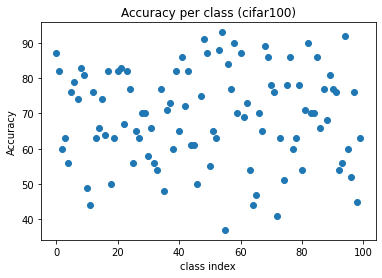

In [40]:
plt.scatter(range(100),values)
sum(acc_per_class.values()).item() / len(test_data)
plt.xlabel('class index')
plt.ylabel('Accuracy')
plt.title('Accuracy per class (cifar100)')
plt.savefig('acc_per_class_cifar100.png')

In [41]:
hard_classes = []
easy_classes = []
for key,value in acc_per_class.items():
    if value > 86:
        easy_classes.append(key)
    if value < 51:
        hard_classes.append(key)
        
print(hard_classes,len(hard_classes))
print(easy_classes,len(easy_classes))

[10, 11, 18, 35, 46, 55, 64, 65, 72, 98] 10
[0, 48, 49, 53, 54, 58, 60, 68, 82, 94] 10


In [42]:
def fgsm_attack(image,model,target,epsilon):
    '''
    Return base_prediction,post_prediction,changed image
    '''
    model.zero_grad()
    predict_0 = predict_image(image,model)
    image = torch.tensor(image)
    image.requires_grad = True
    output = model(image.unsqueeze(0).to(device))
    loss = F.cross_entropy(output,torch.tensor(target).unsqueeze(0).to(device))
    loss.backward()
    changed_image = image + epsilon * image.grad.data.sign()
    changed_image = torch.clamp(changed_image, min=-2.5, max=2.5).detach_()
    predict_1 = predict_image(changed_image,model)
    return predict_0,predict_1,changed_image

In [43]:
def pgd_attack(model, image, label, eps=0.4, alpha=6/255, max_iters=10) :
    image = image.to(device).unsqueeze(0)
    label = torch.tensor(label).to(device).unsqueeze(0)
    loss = nn.CrossEntropyLoss()
        
    ori_image = image.data
        
    for i in range(max_iters) :    
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()

        adv_image = image + alpha*image.grad.sign()
        eta = torch.clamp(adv_image - ori_image, min=-eps, max=eps)
        image = torch.clamp(ori_image + eta,min=-2.5, max=2.5).detach_() #min=-2.5, max=2.5
        changed_label = predict_image(image.squeeze(0),model)
        if changed_label != label:
          break
            
    return i + 1

In [44]:
from tqdm import tqdm

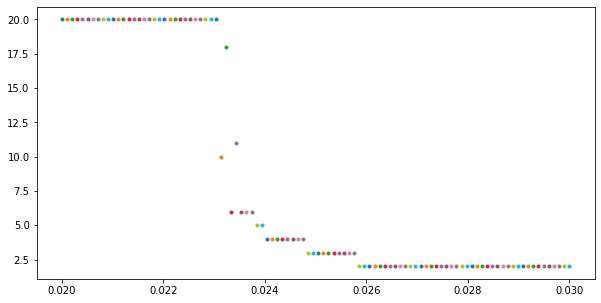

In [48]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1) 

# for i in range(50):
#     ax.set_xlim(0, 50)
#     ax.plot(i, 1 / np.sqrt(i), marker='o')
#     display(fig)    
#     clear_output(wait = True)
#     plt.pause(0.1)

test_img,true_label = test_data[905]
for eps in np.linspace(0.02,0.03,100):
  steps = pgd_attack(model,test_img,true_label,eps=eps,max_iters=20)
  ax.plot(eps,steps,marker='.')
  display(fig)
  clear_output(wait=True)
  plt.pause(0.01)

In [51]:
test_img,true_label = test_data[138]
eps_array = np.linspace(0.02,0.03,70)
steps = []
for eps in tqdm(eps_array):
  steps.append(pgd_attack(model,test_img,true_label,eps=eps,max_iters=25))

100%|██████████| 70/70 [00:18<00:00,  3.80it/s]


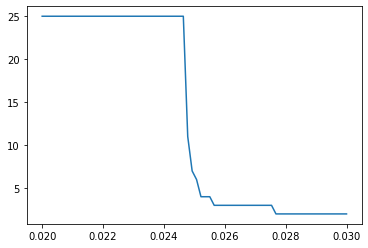

In [52]:
plt.plot(eps_array,steps,animated=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


DINOSAUR FOX


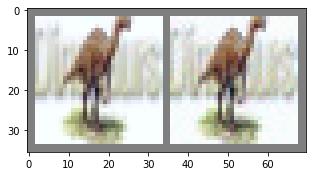

In [54]:
test_img,true_label = test_data[1090]
pred_0,pred_1,changed_img = fgsm_attack(test_img,model,true_label,0.1)
print(test_data.classes[pred_0].upper(),test_data.classes[pred_1].upper())
imshow(torchvision.utils.make_grid([test_img.detach(),changed_img]))

In [55]:
interes_classes = hard_classes + easy_classes
print(interes_classes)
num_classes = len(interes_classes)

[10, 11, 18, 35, 46, 55, 64, 65, 72, 98, 0, 48, 49, 53, 54, 58, 60, 68, 82, 94]


In [58]:
def test( model, device, test_data, epsilon):
    adv_images = []
    adv_success = dict(zip(interes_classes,[0]*num_classes))
    for data, target in tqdm(test_data):
        if target in interes_classes:
            label0,label1,change_img = fgsm_attack(data,model,target,epsilon)
            if target == label0 and label1 != target:
                    adv_success[target] += 1
                    adv_images.append([label0,label1,data,change_img])

    return adv_images,acc_per_class,adv_success

In [61]:
eps = np.linspace(0.01,0.2,20)
success_per_eps = {ep: [] for ep in eps}

In [62]:
for epsilon in eps:
    adv_images, acc, adv_success = test(model, device, test_data, epsilon)
    success_per_eps[epsilon] = adv_success

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
100%|██████████| 10000/10000 [00:57<00:00, 175.13it/s]


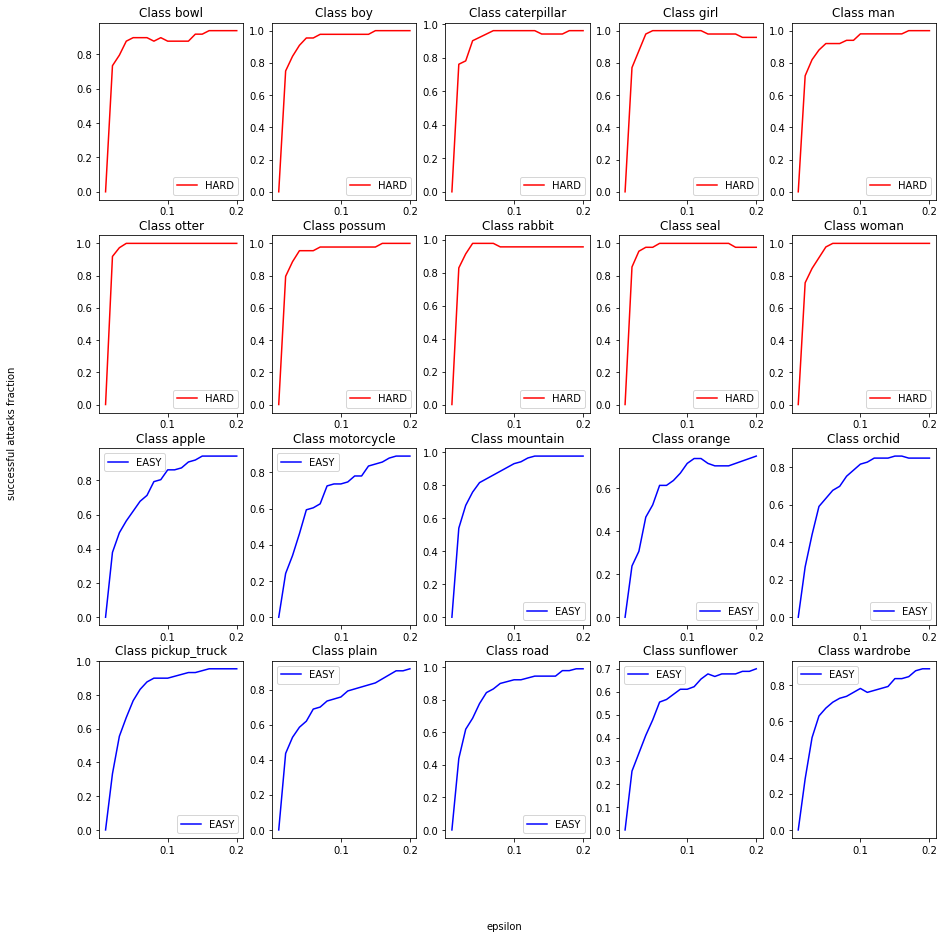

In [63]:
test_cls = test_data.classes

fig,axes = plt.subplots(4,5,figsize=(15,15))
fig.text(0.5, 0.04, 'epsilon', ha='center')
fig.text(0.04, 0.5, 'successful attacks fraction', va='center', rotation='vertical')

for index,class_label in enumerate(interes_classes):
    success = [0]
    eps = [0] + eps
    for ep in eps[1:]:
        success.append(success_per_eps[ep][class_label]/acc_per_class[class_label].item())
    row = index // 5
    column = index % 5
    if class_label in easy_classes:
        label = 'EASY'
        color = 'BLUE'
    else:
        label = 'HARD'
        color = 'RED'
    axes[row,column].plot(eps,success,label=label,color=color)
    axes[row,column].set_title(f'Class {test_cls[class_label]}')
    axes[row,column].legend()

MAN                      SNAIL


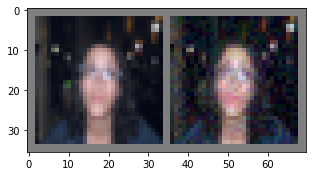

In [66]:
cl1,cl2,img1,img2 = adv_images[10]
print(test_cls[cl1].upper(),' '*20,test_cls[cl2].upper())
imshow(torchvision.utils.make_grid([img1,img2]))

In [73]:
def robust_test(model,device,test_data,eps_range,interes_classes,alpha):
  num_classes = len(interes_classes)
  history_per_class = dict()
  for cl in interes_classes:
    history_per_class[cl] = np.array([0]*len(eps_range))
  for data,target in tqdm(test_data):
    if target not in interes_classes:
      continue
    else:
      if target == predict_image(data,model):
        steps = []
        for eps in eps_range:
          steps.append(pgd_attack(model,data,target,eps=eps,alpha=alpha,max_iters=30))
        steps = np.array(steps)
        history_per_class[target] += steps

  return history_per_class

Test for eps in np.linspace(0.1,0.3,100)
alpha = 4/255

In [75]:
eps_range = np.linspace(0.02,0.2,70)
history_per_hardclass = robust_test(model,device,test_data,eps_range,hard_classes,alpha=4/255)
history_per_easyclass = robust_test(model,device,test_data,eps_range,easy_classes,alpha=4/255)

100%|██████████| 10000/10000 [1:24:04<00:00,  1.98it/s]


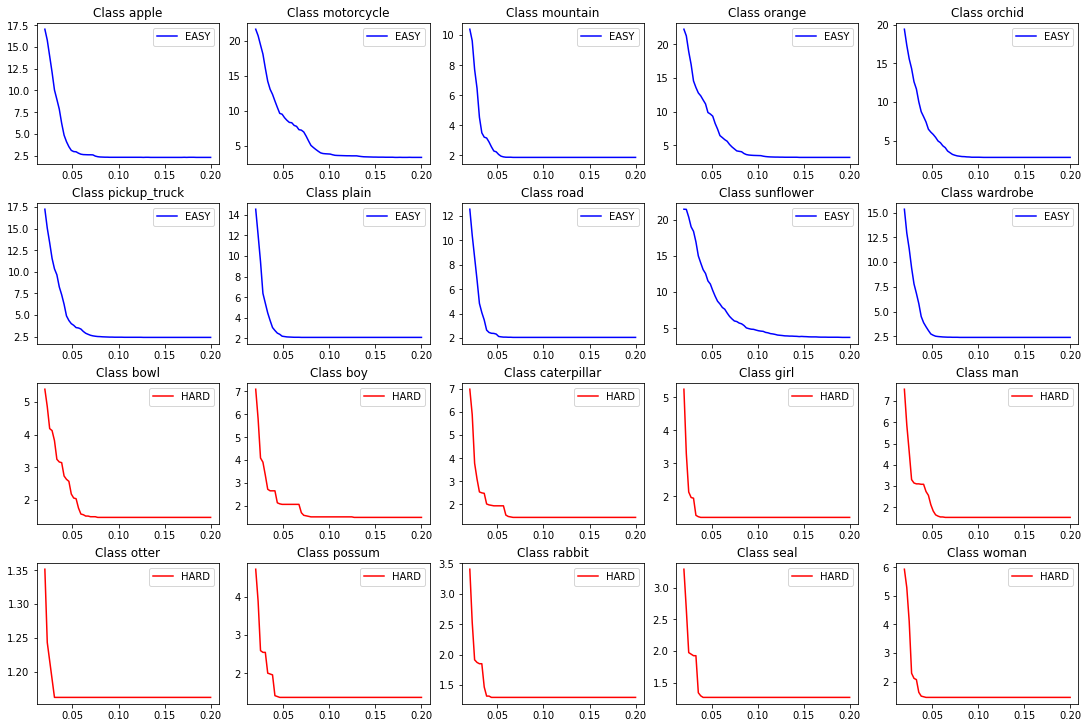

In [85]:
test_cls = test_data.classes
interes_classes = easy_classes + hard_classes

fig,axes = plt.subplots(4,5,figsize=(15,10),constrained_layout=True)
for index,class_label in enumerate(interes_classes):
    row = index // 5
    column = index % 5
    if class_label in easy_classes:
        label = 'EASY'
        color = 'BLUE'
        history = history_per_easyclass[class_label]
    else:
        label = 'HARD'
        color = 'RED'
        history = history_per_hardclass[class_label]
        
    axes[row,column].plot(eps_range,history/acc_per_class[class_label].item(),label=label,color=color)
    axes[row,column].set_title(f'Class {test_cls[class_label]}')
    axes[row,column].legend()

In [86]:
plt.savefig('steps_vs_epsilon.png')

<Figure size 432x288 with 0 Axes>

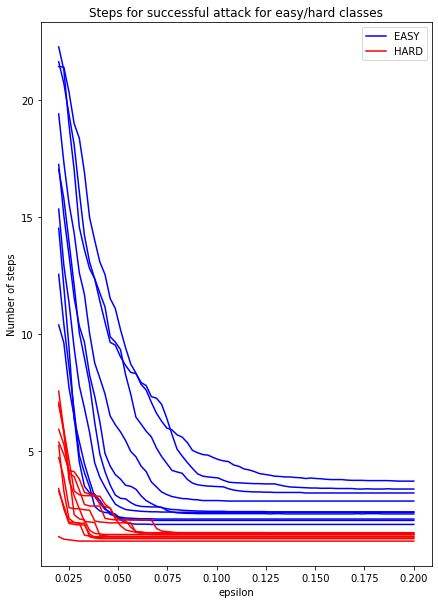

<Figure size 432x288 with 0 Axes>

In [108]:
plt.figure(figsize = (7,10))
for index,class_label in enumerate(interes_classes):
    if class_label in easy_classes:
        label = 'EASY'
        color = 'BLUE'
        history = history_per_easyclass[class_label]
    else:
        label = 'HARD'
        color = 'RED'
        history = history_per_hardclass[class_label]
    label = label if index == 0 or index == 19 else None    
    plt.plot(eps_range,history/acc_per_class[class_label].item(),label=label,color=color)
plt.title('Steps for successful attack for easy/hard classes')
plt.xlabel('epsilon')
plt.ylabel('Number of steps')
plt.legend()
plt.show()
plt.savefig('steps_all.png')

(70,)


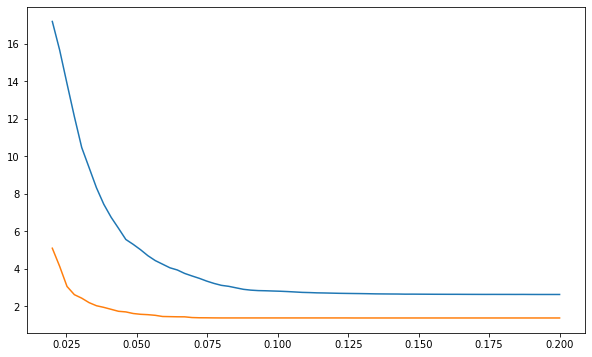

In [115]:
plt.figure(figsize = (10,6))
easy_history_average = np.array([history_per_easyclass[key] / acc_per_class[key].item() for key in history_per_easyclass.keys()]).mean(axis=0)
hard_history_average = np.array([history_per_hardclass[key] / acc_per_class[key].item() for key in history_per_hardclass.keys()]).mean(axis=0)
print(hard_history_average.shape)

plt.plot(eps_range,easy_history_average)
plt.plot(eps_range,hard_history_average)